# Example 2 - no missingness

In [1]:
import numpy as np
import time
import sys, os
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

import seaborn as sns

import matplotlib.pyplot as plt

d = 4
alpha = 1
betas = np.ones(d)
gammas = np.ones(d)

%run 'all_imputations.ipynb'
%run 'all_classifiers.ipynb'

In [2]:
''' Set Constants '''
iterations = 100 # number of iterations for estimating the empirical test error
N_test = 1000

d = 4 # dimension of X, number of variables
alpha = 1
beta = 1
gamma = np.ones(d)
gamma_max = np.amax(gamma)

Omega_star = []
Omega_star.append(np.array([0,1,1,0],dtype="int"))
Omega_star.append(np.array([0,0,0,1],dtype="int"))

def eta(x):
    return 1/2 + (x[2]-1/2)*(x[1]**2)/2 + (x[3]-1/2)/2

Bayes_risk = 0
for _ in range(1000000):
    eta_point = eta(np.random.uniform(size=d))
    Bayes_risk += min(eta_point,1-eta_point)
Bayes_risk = Bayes_risk/1000000
print('Bayes risk = ', np.round(Bayes_risk,4))

Bayes risk =  0.3667


Runtime Complete Case kNN (in s):  3.575
    Accuracy:  0.552
Runtime Oracle HAM (in s):  54.079
    Accuracy:  0.589
Runtime HAM (in s):  90.858
    Accuracy:  0.578
alpha =  0.5
betas =  [1 1 1 1]
gammas =  [2 2 2 2]
Runtime cvHAM (in s):  2873.268
    Accuracy:  0.595

Estimated runtime (in min):  5036.3


Test Accuracy Complete Case kNN:  0.5475
Test Accuracy HAM:  0.5859
Test Accuracy cvHAM:  0.5886
Test Accuracy Oracle HAM:  0.5972


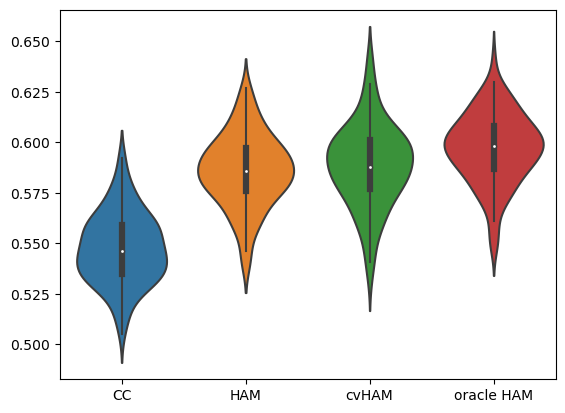

In [3]:
'''
EXAMPLE 2 - no missingness
'''

N_train = 1000 


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.random.uniform(size=(N_train,d))  
Y_train = np.zeros(N_train)
O_train = np.ones((N_train,d))
for i in range(N_train):
    Y_train[i] = np.random.random() < eta(X_train[i,:])  

# Generate Test Points
x_test = np.random.uniform(size=(N_test,d))  
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.random() < eta(x_test[i,:]) 
    
%run 'run_different_classifiers_on_data_and_print_times.ipynb'



''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.random.uniform(size=(N_train,d))  
    Y_train = np.zeros(N_train)
    O_train = np.ones((N_train,d))
    for i in range(N_train):
        Y_train[i] = np.random.random() < eta(X_train[i,:])  

    # Generate Test Points
    x_test = np.random.uniform(size=(N_test,d))  
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.random() < eta(x_test[i,:]) 
        
    %run 'run_different_classifiers_on_data.ipynb'
    
    
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_HAM,accuracy_cvHAM,accuracy_oracle_HAM]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','HAM','cvHAM','oracle HAM'])

plt.show(summary_plot)

In [4]:
''' Save accuracies for further use '''

np.save('Ex2_no_missingness_all_accuracies_cc_kNN',accuracy_cc_kNN[0:iterations])
np.save('Ex2_no_missingness_all_accuracies_oracle_HAM',accuracy_oracle_HAM[0:iterations])
np.save('Ex2_no_missingness_all_accuracies_HAM',accuracy_HAM[0:iterations])
np.save('Ex2_no_missingness_all_accuracies_cvHAM',accuracy_cvHAM[0:iterations])
np.save('Ex2_no_missingness_Bayes_risk',Bayes_risk)